## Data Import and Cleaning

In [2]:
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [8]:
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [33]:
df = pd.read_csv('OnlineRetail.csv', encoding='utf-8')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [34]:
df_uk = df.query("Country == 'United Kingdom'").reset_index(drop = True)

In [35]:
df_users = pd.DataFrame(df['CustomerID'].unique())
df_users.columns = ['CustomerID']

## Recency

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [36]:
df_max_purchase = df_uk.groupby('CustomerID').InvoiceDate.max().reset_index()

In [38]:
df_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [41]:
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max()- df_max_purchase['MaxPurchaseDate']).dt.days

In [45]:
df_users = pd.merge(df_users, df_max_purchase[['CustomerID','Recency']], on = 'CustomerID')

In [47]:
plot_data = [
    go.Histogram(
        x=df_users['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### K-Means Elbow Method

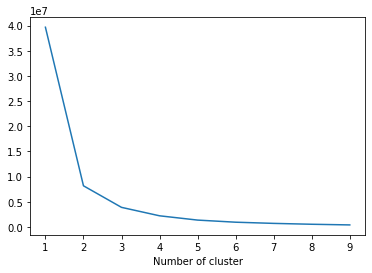

In [48]:
from sklearn.cluster import KMeans

sse={}
df_recency = df_users[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [49]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(df_users[['Recency']])
df_users['RecencyCluster'] = kmeans.predict(df_users[['Recency']])

In [51]:
df_users.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,954.0,78.257862,22.864594,49.0,60.0,73.0,94.00,131.0
1,480.0,304.668750,41.322913,245.0,267.0,301.0,336.25,373.0
2,1950.0,18.016410,13.254688,0.0,7.0,16.0,29.00,47.0
3,566.0,184.973498,31.620611,133.0,157.0,184.0,212.00,243.0


In [52]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [53]:
df_users = order_cluster('RecencyCluster','Recency',df_users,False)

## Frequency

To create frequency clusters, we need to find total number orders for each customer. First calculate this and see how frequency look like in our customer database:

In [56]:
df_frequency = df_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID','Frequency']

In [57]:
df_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [58]:
df_users = pd.merge(df_users, df_frequency, on = 'CustomerID')

### K-means elbow method

C:\Users\Trung.Pham\AppData\Local\Continuum\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Trung.Pham\AppData\Local\Continuum\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Trung.Pham\AppData\Local\Continuum\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

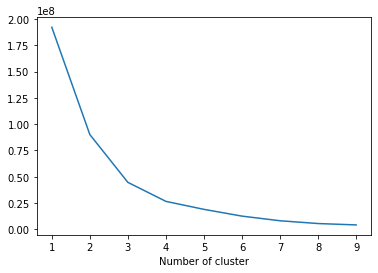

In [60]:
sse={}
df_frequency = df_users[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_frequency)
    df_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [61]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_users[['Frequency']])
df_users['FrequencyCluster'] = kmeans.predict(df_users[['Frequency']])

In [62]:
df_users.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
1,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0


In [63]:
df_users = order_cluster('FrequencyCluster', 'Frequency',df_users,True)

In [64]:
df_users

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850.0,302,0,312,1
1,15808.0,306,0,210,1
2,13047.0,31,3,196,1
3,14688.0,7,3,359,1
4,16029.0,38,3,274,1
5,13408.0,1,3,501,1
6,13767.0,2,3,399,1
7,13448.0,16,3,199,1
8,15513.0,31,3,314,1
9,17920.0,4,3,696,1


## Monetary Value

Total Revenue per customer

In [65]:
df_uk['Revenue'] = df_uk['UnitPrice'] * df_uk['Quantity']
df_revenue = df_uk.groupby('CustomerID').Revenue.sum().reset_index()

In [66]:
df_users = pd.merge(df_users, df_revenue, on='CustomerID')

In [ ]:
sse={}
df_revenue = df_users[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [67]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_users[['Revenue']])
df_users['RevenueCluster'] = kmeans.predict(df_users[['Revenue']])

In [68]:
df_users = order_cluster('RevenueCluster', 'Revenue',df_users,True)

## Overall Segmentation

In [70]:
df_users['OverallScore'] = df_users['RecencyCluster'] + df_users['FrequencyCluster'] + df_users['RevenueCluster']

In [71]:
df_users.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,304.852941,21.964286,302.914874
1,185.710714,32.660714,499.144180
2,79.571739,46.963043,868.082991
3,21.230973,68.419590,1091.416414
4,15.392617,271.755034,3607.097114
5,10.148649,373.290541,9136.946014
6,8.222222,876.037037,22777.914815
7,2.285714,1272.714286,103954.025714
8,1.666667,5917.666667,42177.930000


In [72]:
df_users

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,17850.0,302,0,312,1,5288.63,1,2
1,14688.0,7,3,359,1,5107.38,1,5
2,13767.0,2,3,399,1,16945.71,1,5
3,15513.0,31,3,314,1,14520.08,1,5
4,14849.0,21,3,392,1,7904.28,1,5
5,12921.0,3,3,741,1,16389.74,1,5
6,13468.0,1,3,306,1,5656.75,1,5
7,17690.0,30,3,258,1,4748.45,1,5
8,17017.0,2,3,268,1,8574.11,1,5
9,15601.0,11,3,414,1,6745.36,1,5


## Segmentation Graph

In [73]:
df_users['Segment'] = 'Low-Value'
df_users.loc[df_users['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_users.loc[df_users['OverallScore']>4,'Segment'] = 'High-Value'

In [74]:
df_graph = df_users.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=df_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=df_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
        ),
        go.Scatter(
        x=df_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=df_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'High-Value'")['Frequency'],
        y=df_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]
plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [75]:
df_users.to_csv('df_customer_segment_complete.csv', index = False)